# 09. 객체탐지 실습
---





```
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os, glob, cv2

from google.colab.patches import cv2_imshow

## 과제: 마스크 탐지
<p align='center'>
<img src=https://github.com/kairess/mask-detection/raw/master/imgs/result.png   width=400>
</p>


---
### 모델1: 탐지
---

* 마스크탐지: 
  1. 이미지를 모델에 넣으면
  1. 이미지에서 얼굴 영역만 찾고
  1. 크롭된 영역만 분류 모델에 넘기기 


---
### 모델2: 분류
---

1. 탐지를 통해 얼굴사진이 들어오면
1. 분류모델을 통해 마스크/하품  판단하기

분류모델은 만들어지지 않았기 때문에 직접 만들도록 합니다.

#### **데이터준비**


* 마스크 데이터 로드

```
! git clone https://github.com/prajnasb/observations.git
```

* 위치: `observations/experiements/data/`

In [ ]:
! git clone https://github.com/prajnasb/observations.git

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638
Receiving objects: 100% (1638/1638), 75.94 MiB | 29.22 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Checking out files: 100% (3045/3045), done.


In [ ]:
! ls observations/experiements/data/

with_mask  without_mask


In [ ]:
from tensorflow.keras import preprocessing

IMG_SIZE = 160
BATCH_SIZE = 8

data_dir = 'observations/experiements/data/'
train_ds = preprocessing.image_dataset_from_directory( data_dir,  # 데이터 폴더 경로 
                                                       subset="training",
                                                       validation_split=0.2,
                                                       image_size=(IMG_SIZE, IMG_SIZE),
                                                       batch_size=BATCH_SIZE,
                                                       seed=123 )

valid_ds = preprocessing.image_dataset_from_directory( data_dir,  # 데이터 폴더 경로 
                                                       subset="validation",
                                                       validation_split=0.2,
                                                       image_size=(IMG_SIZE, IMG_SIZE),
                                                       batch_size=BATCH_SIZE,
                                                       seed=123 )

Found 1376 files belonging to 2 classes.
Using 1101 files for training.
Found 1376 files belonging to 2 classes.
Using 275 files for validation.


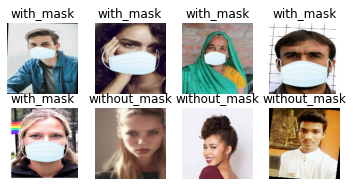

In [ ]:
plt.figure(figsize=(6,6))
for imgs, labels in train_ds.take(1):
  for i, (img, label) in enumerate(zip(imgs, labels)):
    plt.subplot(4,4, i+1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(train_ds.class_names[label])
    plt.axis('off')

#### **모델 학습**

In [ ]:
from tensorflow.keras import layers, models, losses, optimizers

aug = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(0.2),                           
])


In [ ]:
from tensorflow.keras import applications
base_model = applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                      include_top=False,
                                      weights='imagenet')
base_model.summary()

In [ ]:
base_model.trainable = False

In [ ]:
x = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
z = aug(x) # 데이터 증강
z = applications.mobilenet_v2.preprocess_input(z)  # 모바일넷에 맞는 전처리 
z = base_model(z, training=False)
z = layers.GlobalAveragePooling2D()(z)
#z = layers.Flatten()(z)
z = layers.Dropout(0.2)(z)
y = layers.Dense(2, activation='softmax')(z)

model = models.Model(x, y)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_2 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

* `callbacks` 을 이용해 학습 중간에 모델을 저장하고 학습률 스케줄링을 지정할 수 있습니다.

In [ ]:
from tensorflow.keras import callbacks

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                        factor = 0.2,
                                        patience=3,
                                        min_lr = 0.000001)
ckp = callbacks.ModelCheckpoint('model.h5', save_best_only=True)

* 컴파일

In [ ]:
model.compile( loss = losses.SparseCategoricalCrossentropy(),
               optimizer = optimizers.RMSprop(learning_rate=0.0001),
               metrics = ['accuracy'] )

* 학습

In [ ]:
history = model.fit( train_ds, 
                     validation_data = valid_ds, 
                     epochs=20,
                     callbacks=[reduce_lr, ckp])

Epoch 1/20
184/184 [==============================] - ETA: 0s - loss: 1.6010 - accuracy: 0.3770WARNING:tensorflow:Model was constructed with shape (160, 160, 3) for input KerasTensor(type_spec=TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name='random_flip_input'), name='random_flip_input', description="created by layer 'random_flip_input'"), but it was called on an input with incompatible shape (None, 160, 160, 3).


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


184/184 [==============================] - 26s 59ms/step - loss: 1.6010 - accuracy: 0.3770 - val_loss: 1.1440 - val_accuracy: 0.5572 - lr: 1.0000e-04
Epoch 2/20
184/184 [==============================] - 9s 49ms/step - loss: 1.0659 - accuracy: 0.5988 - val_loss: 0.8411 - val_accuracy: 0.6935 - lr: 1.0000e-04
Epoch 3/20
184/184 [==============================] - 9s 50ms/step - loss: 0.8461 - accuracy: 0.6904 - val_loss: 0.6920 - val_accuracy: 0.7452 - lr: 1.0000e-04
Epoch 4/20
184/184 [==============================] - 9s 49ms/step - loss: 0.7382 - accuracy: 0.7326 - val_loss: 0.6067 - val_accuracy: 0.7888 - lr: 1.0000e-04
Epoch 5/20
184/184 [==============================] - 9s 49ms/step - loss: 0.6463 - accuracy: 0.7582 - val_loss: 0.5550 - val_accuracy: 0.8174 - lr: 1.0000e-04
Epoch 6/20
184/184 [==============================] - 9s 48ms/step - loss: 0.5956 - accuracy: 0.7909 - val_loss: 0.5163 - val_accuracy: 0.8324 - lr: 1.0000e-04
Epoch 7/20
184/184 [==============================

---
### 탐지 전체 플로우
---

이미지 -> ( **탐지모델** ) -> 얼굴 크롭된 이미지 -> ( **분류모델** ) -> visualization 된 이미지 

In [ ]:
! git clone https://github.com/yebiny/Face-detection-for-DSM.git

In [ ]:
facenet = cv2.dnn.readNet(DIR+"/models/deploy.prototxt", 
                          DIR+"/models/res10_300x300_ssd_iter_140000.caffemodel")

# pass the blob through the network and obtain the face detections
print("[INFO] computing face detections...")
# construct a blob from the image
blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300),
	(104.0, 177.0, 123.0))
facenet.setInput(blob)
detections = facenet.forward()

faces=[]
for i in range(detections.shape[2]):
  conf = detections[0,0,i,2]
  if conf <0.5:
    continue
  x1 = int(detections[0,0,i,3]*img_w)
  y1 = int(detections[0,0,i,4]*img_h)
  x2 = int(detections[0,0,i,5]*img_w)
  y2 = int(detections[0,0,i,6]*img_h)

  face = img[y1:y2, x1:x2]
  faces.append(face)

In [ ]:
for face in faces:
  img = tf.image.resize(images=face,
                        size=[IMG_SIZE, IMG_SIZE])
  img = tf.expand_dims(img, axis=0)

  # predict
  (mask, withoutMask) = model.predict(img)[0]
  print( mask, withoutMask)

  # visualize
  label = "Mask" if mask > withoutMask else "No Mask"
  color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
  label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

  cv2.putText(img, label, (x1, y2 - 10),
              cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
  cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
  cv2_imshow(img)